# Audio de-clipping 

When recording an audio signal
generated from a loud source 
the microphone can saturate.
This results in a _clipped audio signal_
which can be severely corrupted with
distortion artifacts.

[Here you can listen to an audio example.](https://kul-forbes.github.io/StructuredOptimization.jl/latest/demos.html).


The clipped signal $\tilde{\mathbf{y}}$ is plotted below:


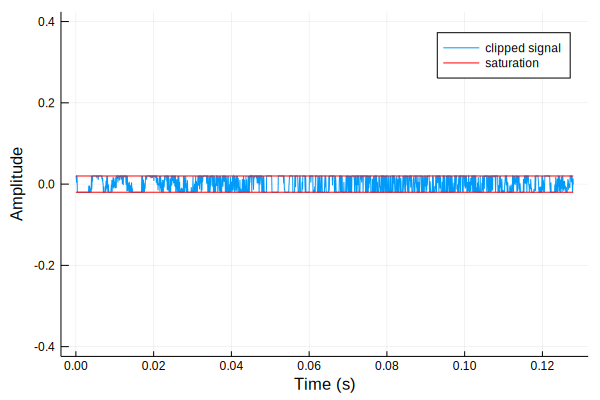

In [1]:
using WAV

yt, Fs = wavread("../docs/src/assets/clipped.wav")
yt = yt[:,1]

# plotting a frame of the audio signal
idxs = 2^11+1:2^12
t = (0:length(idxs)-1)./Fs
C = maximum(abs.(yt))      # clippint level

using Plots
plot(t, yt[idxs]; label = "clipped signal", xlabel="Time (s)", ylabel="Amplitude", ylim=[-0.4; 0.4])
plot!([0;t[end]],  C.*ones(2); color=:red, label = "saturation")
plot!([0;t[end]],  -C.*ones(2); color=:red, label = "")

As it can be seen, all of the samples of the recorded signal below and above the saturation level are _lost_ during the recording phase. 

This is what causes the distortion artifacts. 

What _audio de-clipping_ seeks is to recover these samples and remove the audio artifacts.

This recovery is performed using a weighted overlap-add method, namely by splitting the audio signal into overlapping frames of length $N_l = 2^{10}$ and processing them serially.

In each frame an optimization problem that combines the uncorrupted samples of the audio signal with the knowledge that the signal is sparse when transformed using the discrete cosine transform (DCT) is solved.

Here there are two optimization variables $\mathbf{y}$ and $\mathbf{x}$ representing the sought de-clipped signal and its DCT transform respectively.

The optimization problem follows:

$$
\begin{aligned}
& \underset{ \mathbf{x}, \mathbf{y} }{\text{minimize}}
& & \frac{1}{2} \| F_{i,c} \mathbf{x}   - \mathbf{y}  \|  ^2, \\ 
& \text{subject to}
& & \| M \mathbf{y} - M \tilde{\mathbf{y}} \|  \leq \epsilon \\
& & & M_{+} \mathbf{y} \geq  C \\
& & & M_{-} \mathbf{y} \leq -C \\
& & & \| \mathbf{x} \|_0 \leq N \\
\end{aligned}
$$

Here $F_{i,c}$ is the inverse DCT transform mapping. $M$, $M_{\pm}$ select the uncorrupted and clipped samples and are used in the first three constraints to keep $\mathbf{y}$ either close to the clipped signal $\tilde{\mathbf{y}}$ at the uncorrupted samples or outside the saturation level respectively.


In the last constraint, the value $N$ represents the number of non-zero elements of $\mathbf{y}$, namely the active components in the DCT: as it is shown below, this value is tuned by solving the optimization problem multiple times by increasing $N$.

As more active components are introduced, the cost function decreases: once its value reaches $\epsilon$ the solution refinement is stopped.

In [2]:
using StructuredOptimization, DSP

C  = maximum(abs.(yt))              # clipping level
Nl = 2^10                           # frames length
Nt = length(yt)                     # signal length
yd = zero(yt)                      # allocate declipped output

x, y = Variable(Nl), Variable(Nl) # optimization variables
f = ls( idct(x) - y )             # cost function
yw = zeros(Nl)                    # allocate weighted clipped frame

#time win options
K = 2 # K = 2 hanning
win = sqrt.(tukey(Nl+1,2/K)[1:Nl])
overlap = div(Nl,K)

ϵ = sqrt(1e-5)  # refinement tolerance 
z = 0           # initial index

winC = C.*win   # clipping level (windowed)

#weighted Overlap-Add
while z+Nl < Nt
        
    fill!(~x,0.) # initialize variables
    fill!(~y,0.)

    Ip = sort(findall(     yt[z+1:z+Nl]  .>=  C) ) #positive clipping indices
    In = sort(findall(     yt[z+1:z+Nl]  .<= -C) ) #negative clipping indices 
    I  = sort(findall(abs.(yt[z+1:z+Nl]) .<   C))  #non clipped indices
    
    yw .= yt[z+1:z+Nl].*win # weighted frame

    if isempty(Ip) && isempty(In) # no clipping, do nothing
        yd[z+1:z+Nl] .+= yw.*win    
        println(I)
    else
        N = 0 # number of active components in DCT
        for N = 30:30:30*div(Nl,30)
            
            cstr = (norm(x,0) <= N,
                    norm(y[I]-yw[I]) <= ϵ,
                    y[Ip] >=  winC[Ip],
                    y[In] <= -winC[In])
                
            @minimize f st cstr with PANOC(tol = 1e-4, verbose = false)    
        
            if norm(idct(~x) - ~y) <= ϵ break end
            
        end
        
        @views yd[z+1:z+Nl] .+= (~y).*win # store declipped signal     
    end
    z += Nl-overlap                       # update index    
end

┌ Warning: stepsize `tau` became too small (0.0009765625), stopping the iterations
└ @ ProximalAlgorithms /Users/nantonel/.julia/packages/ProximalAlgorithms/BUA2U/src/algorithms/panoc.jl:182
┌ Warning: stepsize `tau` became too small (0.0009765625), stopping the iterations
└ @ ProximalAlgorithms /Users/nantonel/.julia/packages/ProximalAlgorithms/BUA2U/src/algorithms/panoc.jl:182
┌ Warning: stepsize `tau` became too small (0.0009765625), stopping the iterations
└ @ ProximalAlgorithms /Users/nantonel/.julia/packages/ProximalAlgorithms/BUA2U/src/algorithms/panoc.jl:182
┌ Warning: stepsize `tau` became too small (0.0009765625), stopping the iterations
└ @ ProximalAlgorithms /Users/nantonel/.julia/packages/ProximalAlgorithms/BUA2U/src/algorithms/panoc.jl:182
┌ Warning: stepsize `tau` became too small (0.0009765625), stopping the iterations
└ @ ProximalAlgorithms /Users/nantonel/.julia/packages/ProximalAlgorithms/BUA2U/src/algorithms/panoc.jl:182
┌ Warning: stepsize `tau` became too small (0

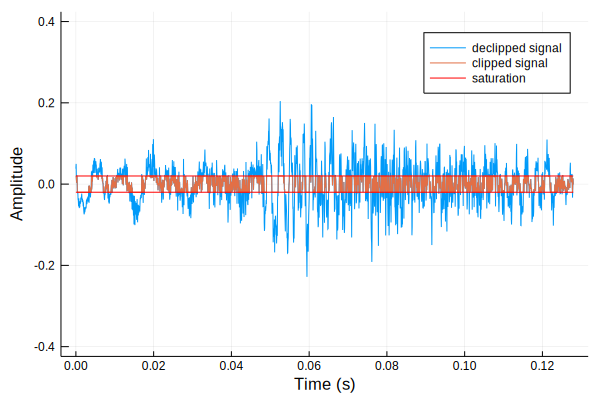

In [3]:
plot(t, yd[idxs], label = "declipped signal", xlabel="Time (s)", ylabel="Amplitude", ylim=[-0.4; 0.4])
plot!(t, yt[idxs]; label = "clipped signal")
plot!([0;t[end]],  C.*ones(2); color=:red, label = "saturation")
plot!([0;t[end]],  -C.*ones(2); color=:red, label = "")

In [4]:
using LinearAlgebra
wavwrite(0.9 .* normalize(yd,Inf), "../docs/src/assets/declipped.wav"; Fs = Fs, nbits = 16, compression=WAVE_FORMAT_PCM) # save wav file

The declipped audio signal distortion artifacts are now removed. 

[Here you can listen to the comparison](https://kul-forbes.github.io/StructuredOptimization.jl/latest/demos.html).
